# Introduction
This project is aimed to use a statistical model to predict the wind stress anomalies by sea surface temperature anomalies (SSTA). The relationship can be represented as $\boldsymbol{\tau_s} = \boldsymbol{C} \boldsymbol{T}$, where $\boldsymbol{\tau_s}$ and $\boldsymbol{T}$ are state vectors of wind stress anomolies and SSTA, respectively, and $\boldsymbol{C}$ is a constant coefficient (a matrix). Our goal is to derive $\boldsymbol{C}$ using Singular Value Decomposition (SVD) analysis on a training dataset, and apply the relationship on a testing dataset.

This project is going to:

1. Formulate a statistical atmosphere model for predicting surface wind stress anomalies for given SST anomalies;
2. Validate the simulated surface wind stress anomalies against observations;
3. Perform sensitivity tests to see how the results depend on the number of SVDs used to compute the anomalies;
4. Discuss whether the results make physical sense and why;

# Dataset and Method
Surface temperature ($T_s$), zonal wind stress ($u$), meridional wind stress ($v$), and a land mask dataset are given. $T_s, u, v$ are three-dimensional, with two space dimensions and one time dimension. Datasets are divided into two parts: data in 1948-1999 are used as training dataset, and data in 2000-2017 are used as testing dataset.

Steps to perform the SVD analysis:

1. Normalize all the anomaly fields by dividing each of variables by its own standard deviation;
2. Form a state vector for SSTA ($\boldsymbol{T}$), and another one for zonal and meridional wind stress anomaly ($\boldsymbol{\tau_s}$). Note that $\boldsymbol{\tau_s}$ contains both wind stress component and has larger dimension than $\boldsymbol{T}$;
3. Form a normalized covariance matrix, $\boldsymbol{A=\tau _s T'}$, whose dimension should be $M\times N$, where $M$ is the length for $\boldsymbol{\tau_s}$ and $N$ is length for $\boldsymbol{T}$;
4. Apply SVD on $\boldsymbol{A}$ by calling Matlab’s SVD function, which results in $\boldsymbol{A=USV'}$, $S$ is a diagonal matrix with diagonal elements representing singular values - explained squared covariance in each SVD, $\boldsymbol{U}$ contains all wind stress singular vectors and $V$ contains all SST singular vectors, which are self-orthogonal, i.e., $\boldsymbol{VV'=I}$ and $\boldsymbol{UU'=I}$;
5. Project $T$ onto each SST SVD mode, $V_i$, gives $i$-th PC time series, $b_i=<V_i'T>/<V_i'Vi>$; Project $\tau _s$ onto each wind stress SVD mode, $U_i$, gives $i$-th PC time series, $d_i=<U_i' \tau _s>/<U_i' U_>$; These pairs of time series should be highly correlated 

# Results
## SVD analysis
Following the above steps, the Python script to perform SVD analysis is below:

In [127]:
import numpy.linalg as la
import xarray as xr
import numpy as np

# read in the data
dir = "./NECP_monthly_mean_data/"
taux_ds = xr.open_dataset(dir + "uflx.sfc.mon.mean.tropics.nc", use_cftime=True)
tauy_ds = xr.open_dataset(dir + "vflx.sfc.mon.mean.tropics.nc", use_cftime=True)
sst_ds = xr.open_dataset(dir + "skt.sfc.mon.mean.tropics.nc", use_cftime=True)
grid_ds = xr.open_dataset(dir + "lsmask.tropics.nc", use_cftime=True)
# get the data
taux_da, tauy_da, sst_da, grid_da = taux_ds.uflx, tauy_ds.vflx, sst_ds.skt, grid_ds.lsmask
# reverse the latitude dimension to make it increasing
taux_da = taux_da.reindex(lat=taux_da.lat[::-1])
tauy_da = tauy_da.reindex(lat=tauy_da.lat[::-1])
sst_da = sst_da.reindex(lat=sst_da.lat[::-1])
grid_da = grid_da.reindex(lat=grid_da.lat[::-1])
# select data from 1948 to 1999 for training, 
# and in a target region (30N-30S, 100E-60W)
lat_min, lat_max = -30, 30
lon_min, lon_max = 100, 300
taux = taux_da.sel(time=slice("1948", "1999"), lon=slice(lon_min, lon_max))
tauy = tauy_da.sel(time=slice("1948", "1999"), lon=slice(lon_min, lon_max))
sst = sst_da.sel(time=slice("1948", "1999"), lon=slice(lon_min, lon_max))
grid = grid_da.sel(lon=slice(lon_min, lon_max))
lat, lon = taux.lat.values, taux.lon.values
time = sst.time.values
# get the data as numpy arrays
taux, tauy, sst, grid = taux.values, tauy.values, sst.values, grid.values
grid = grid[0,:,:]
# get dimensions
nt, ny, nx = taux.shape
# reshape the time dimension to nmonths x nyears
taux = taux.reshape(nt//12, 12, ny, nx)
tauy = tauy.reshape(nt//12, 12, ny, nx)
sst = sst.reshape(nt//12, 12, ny, nx)
# get seasonal means
taux_mean = taux.mean(axis=0, keepdims=True)
tauy_mean = tauy.mean(axis=0, keepdims=True)
sst_mean = sst.mean(axis=0, keepdims=True)
# remove seasonal cycle
taux_anom = taux - taux_mean
tauy_anom = tauy - tauy_mean
sst_anom = sst - sst_mean
# reshape time to 1D
taux_anom = taux_anom.reshape(nt, ny, nx)
tauy_anom = tauy_anom.reshape(nt, ny, nx)
sst_anom = sst_anom.reshape(nt, ny, nx)
# normalize the data by the standard deviation
taux_std = taux_anom.std()
taux_anom /= taux_std
tauy_std = tauy_anom.std()
tauy_anom /= tauy_std
sst_std = sst_anom.std()
sst_anom /= sst_std
# mask out the land
taux_anom[:, grid == -1] = 0
tauy_anom[:, grid == -1] = 0
sst_anom[:, grid == -1] = 0
# concatenate taux and tauy
tau = np.concatenate((taux_anom, tauy_anom), axis=1)
# reshape vars to space x time
tau = tau.reshape(nt, 2*ny*nx).T 
sst = sst_anom.reshape(nt, ny*nx).T
# form matrix A
A = 1/nt * tau @ sst.T
# apply SVD on A
U, S, V = la.svd(A, full_matrices=True)

In [124]:
print("Shape of U:", U.shape)
print("Shape of S:", S.shape)
print("Shape of V:", V.shape)
n_modes = 10
# get the explained variance
var = (S**2) / (S**2).sum()
# get the first n_modes modes
tau_modes = U[:, :n_modes]
sst_modes = V[:n_modes, :]
sigma_modes = S[:n_modes]
var_modes = var[:n_modes]
print(f"First {n_modes} sigma values:", sigma_modes)
print(f"First {n_modes} explained variance:", var_modes)
# get the spatial patterns
tau_modes = tau_modes.reshape(2*ny, nx, n_modes)
taux_modes = tau_modes[:ny, :, :]
tauy_modes = tau_modes[ny:, :, :]
sst_modes = sst_modes.reshape(n_modes, ny, nx)

Shape of U: (6848, 6848)
Shape of S: (3424,)
Shape of V: (3424, 3424)
First 10 sigma values: [343.34018  119.610916 102.532234  62.98886   51.755688  42.648064
  39.13009   35.601448  29.313498  27.253736]
First 10 explained variance: [0.7359658  0.08932026 0.06563405 0.02477056 0.0167234  0.01135552
 0.00955939 0.00791305 0.00536468 0.00463725]


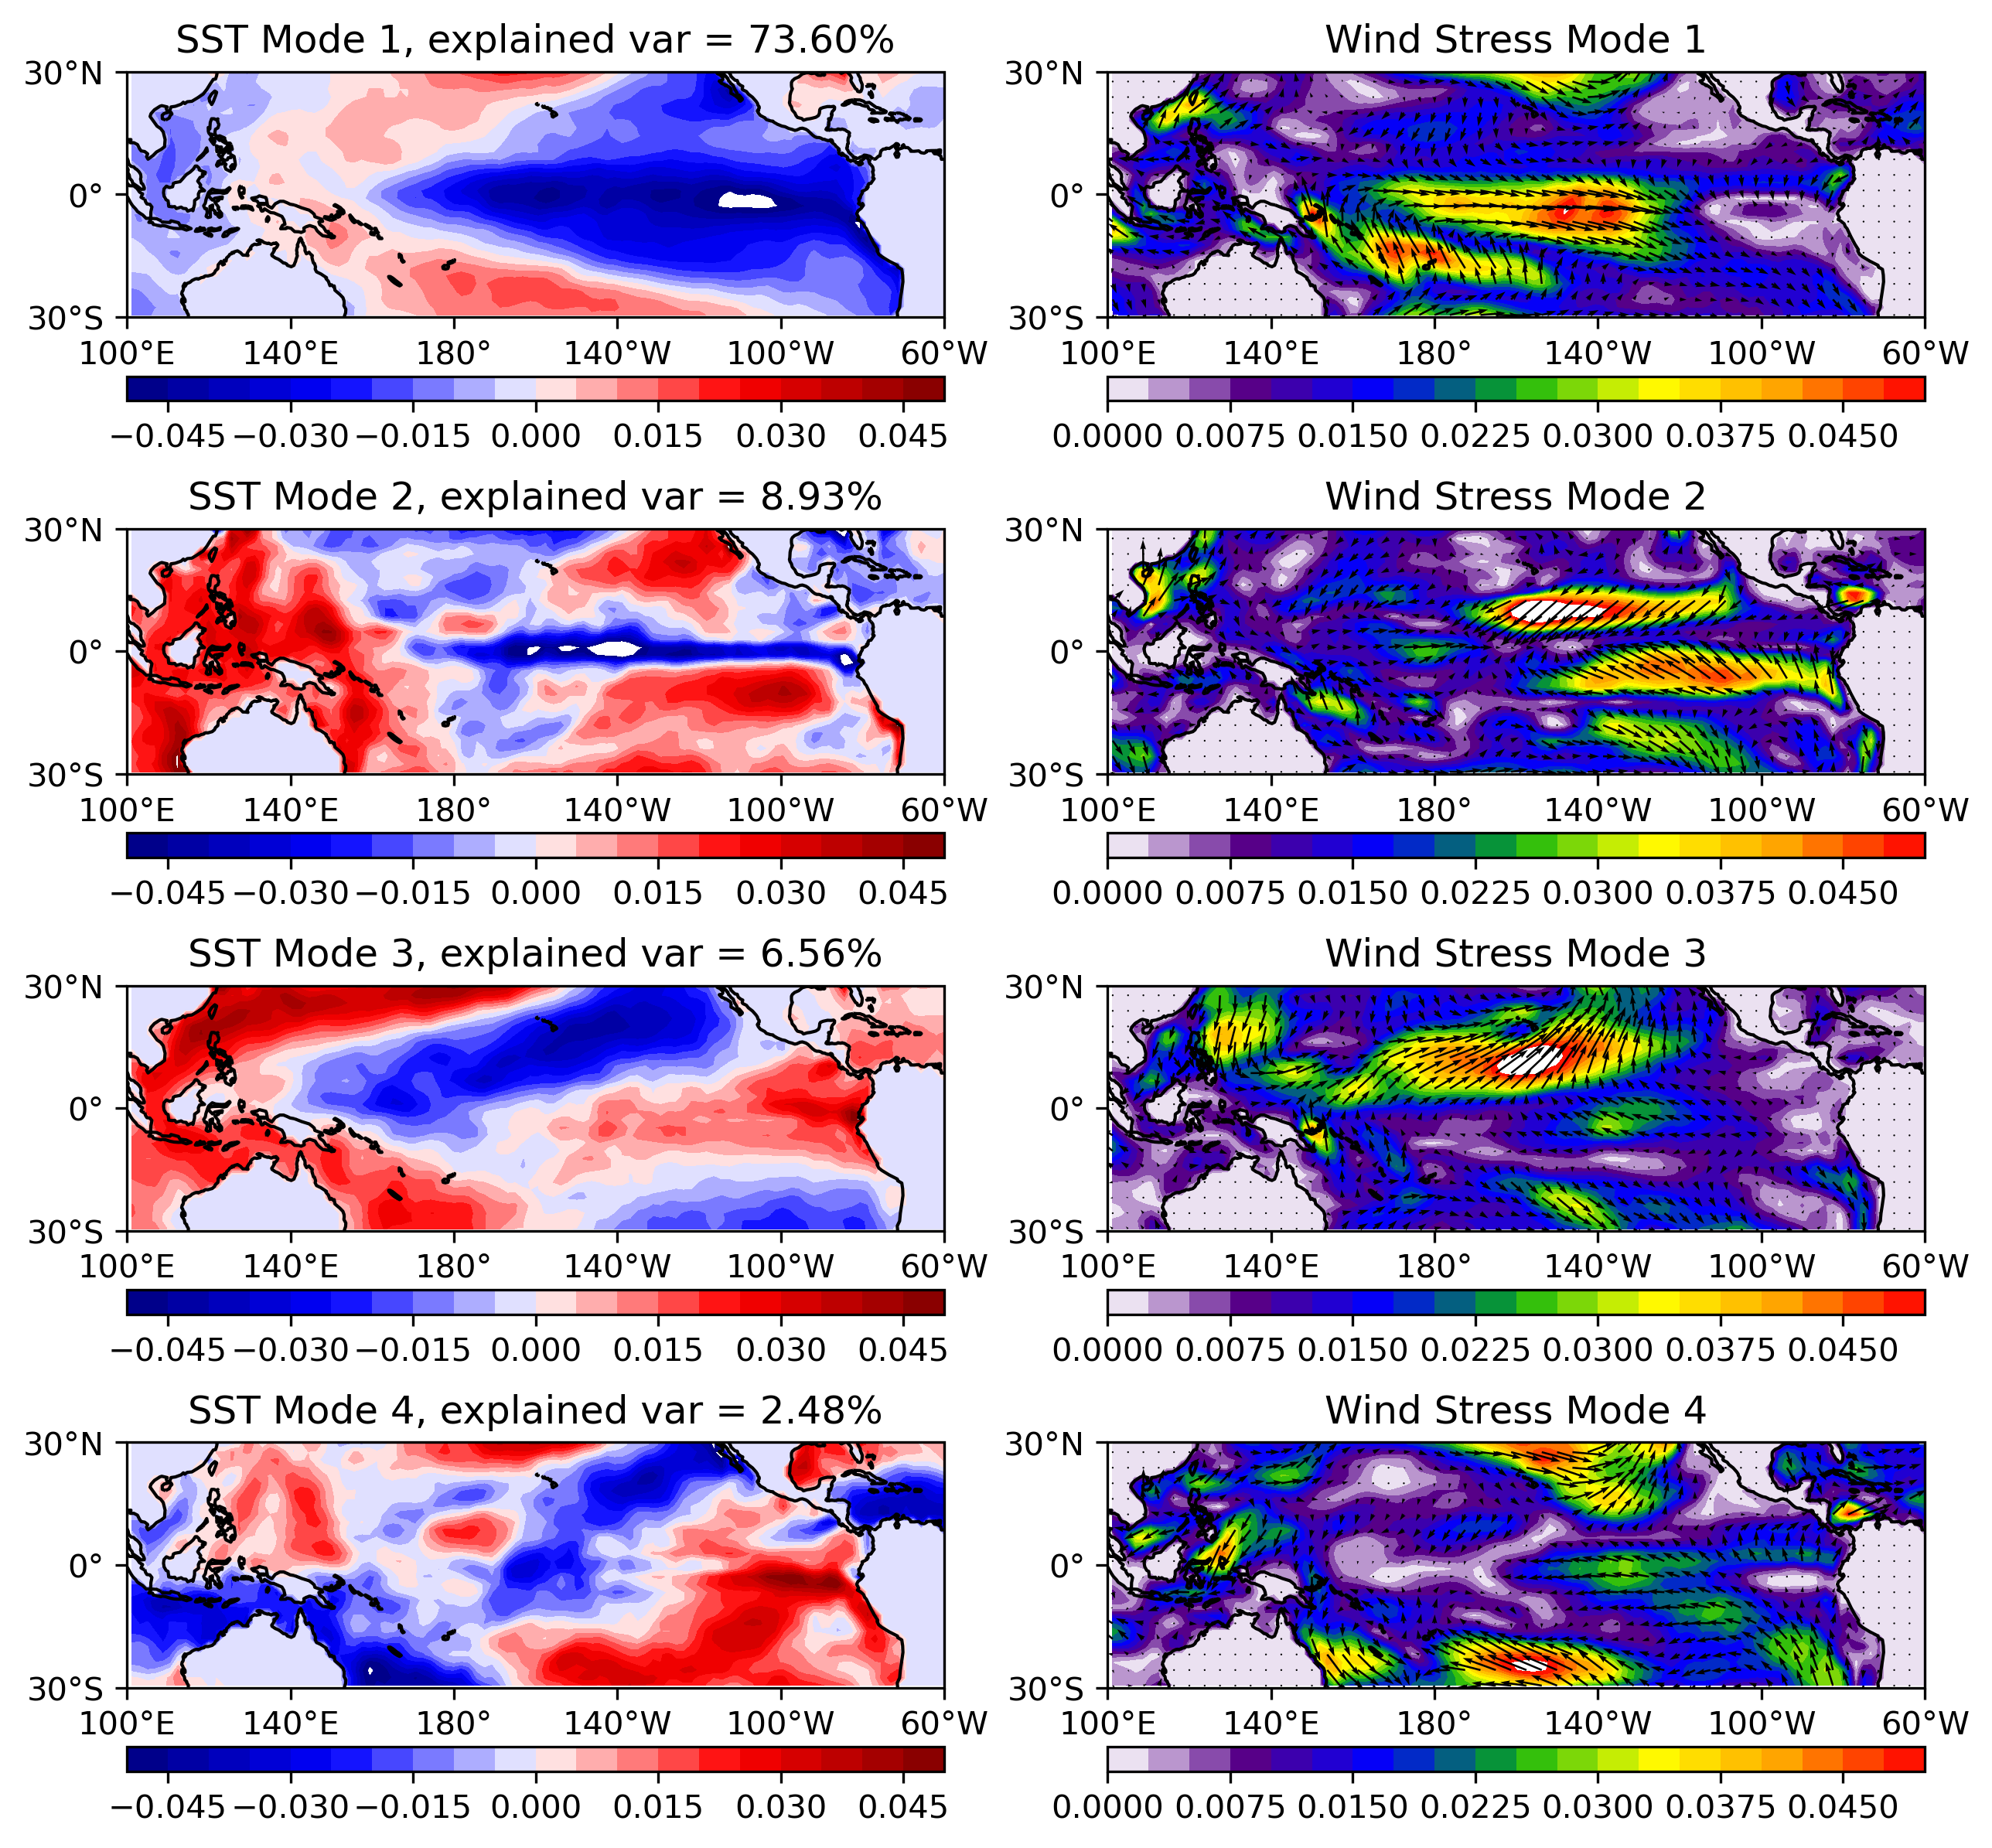

In [125]:
# plot the spatial patterns
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cmaps
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

plot_modes = 4
projection = ccrs.PlateCarree(central_longitude=180)
fig, axes = plt.subplots(plot_modes, 2, figsize=(10, 10), 
            subplot_kw={'projection': projection}, dpi=300)
for i in range(plot_modes):
    ax = axes[i, 0]
    # set extent
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    ax.set_title("SST Mode " + str(i+1) + f", explained var = {var_modes[i]*100:.2f}%")
    levels = np.linspace(-0.05, 0.05, 21)
    p1 = ax.contourf(lon, lat, sst_modes[i, :,:], transform=ccrs.PlateCarree(), 
                    levels=levels, cmap=cmaps.BlWhRe)
    # lat and lon ticks
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.set_xticks(np.arange(lon_min, lon_max+1, 40), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_min, lat_max+1, 30), crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    # add colorbar below the plot
    axins = inset_axes(ax,
                    width="100%",  
                    height="10%",
                    loc='lower center',
                    borderpad=-2.6,
                   )
    fig.colorbar(p1, cax=axins, orientation="horizontal")
    ax.coastlines()
    ax = axes[i, 1]
    # set extent
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    tau_mag = np.sqrt(taux_modes[:,:,i]**2 + tauy_modes[:,:,i]**2)
    ax.set_title("Wind Stress Mode " + str(i+1))
    levels = np.linspace(0, 0.05, 21)
    p2 = ax.contourf(lon, lat, tau_mag, transform=ccrs.PlateCarree(), 
                levels=levels, cmap=cmaps.WhViBlGrYeOrRe)
    # add wind arrows
    ax.quiver(lon[::2], lat[::2], taux_modes[::2, ::2, i], tauy_modes[::2, ::2, i],
                transform=ccrs.PlateCarree(), scale=1, color='k')
    # lat and lon ticks
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.set_xticks(np.arange(lon_min, lon_max+1, 40), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_min, lat_max+1, 30), crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    # add colorbar below the plot
    axins = inset_axes(ax,
                    width="100%",
                    height="10%",
                    loc='lower center',
                    borderpad=-2.6,
                     )
    fig.colorbar(p2, cax=axins, orientation="horizontal")
    ax.coastlines()
plt.show()

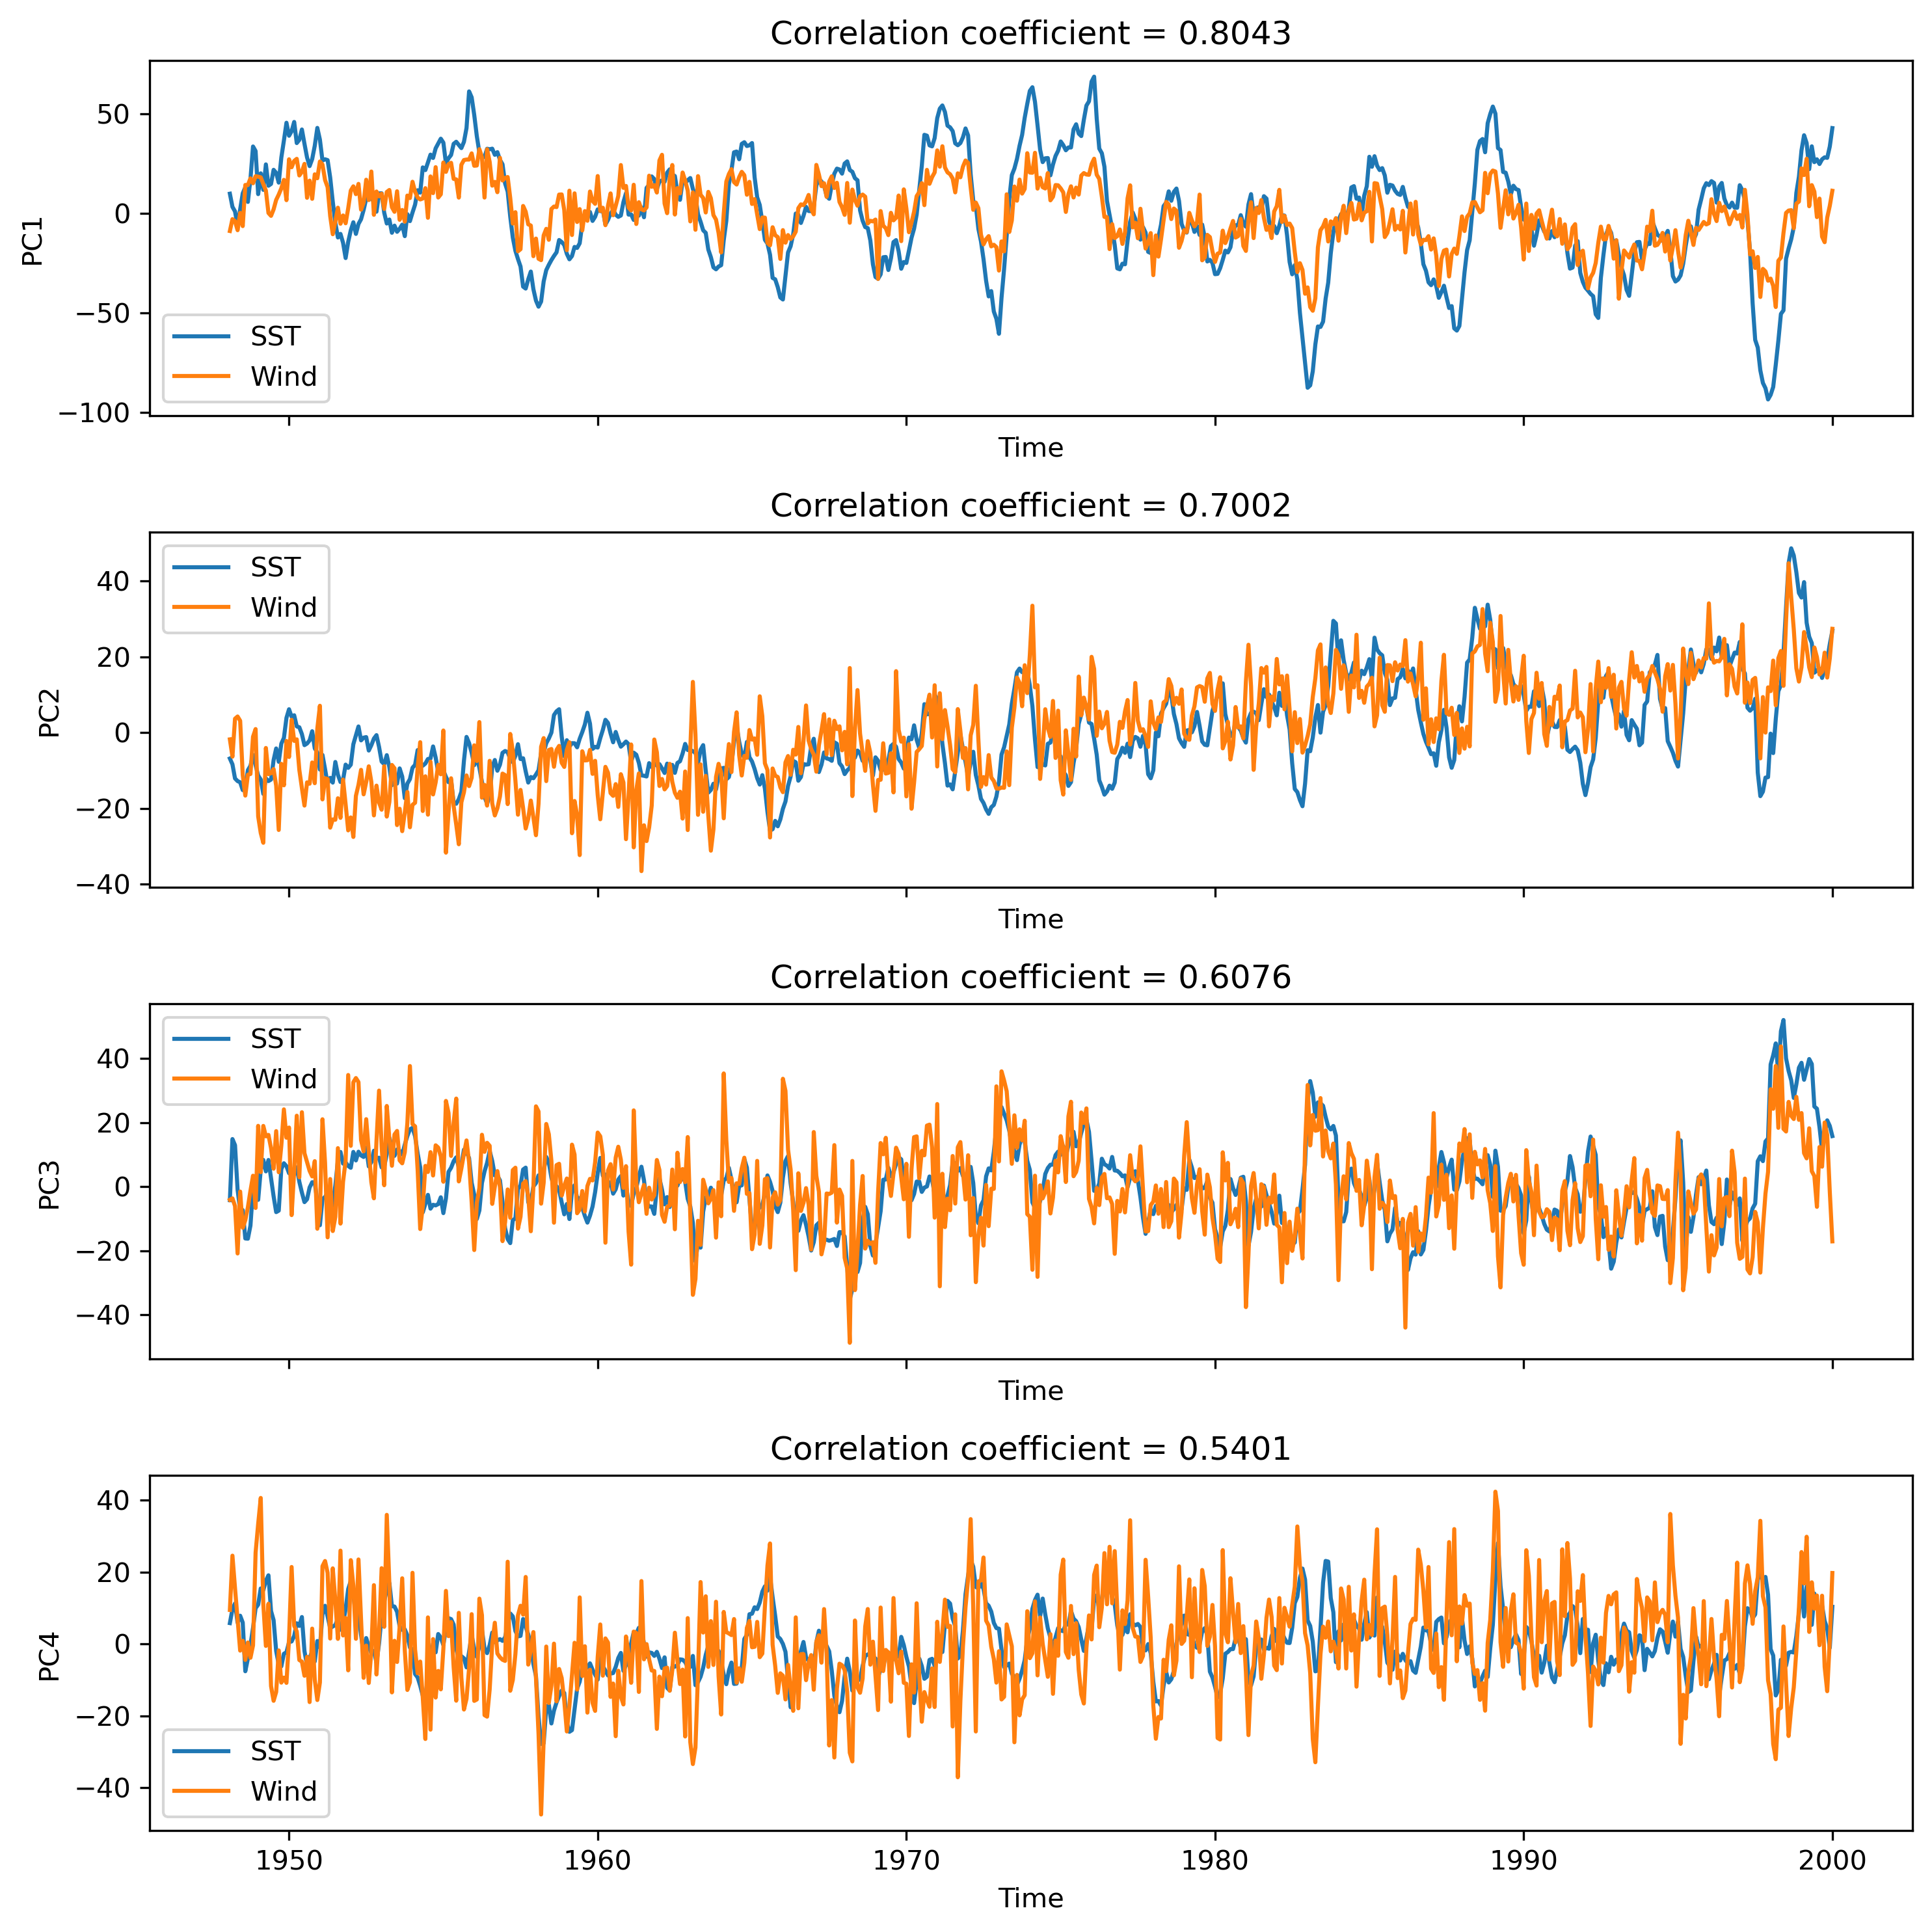

In [126]:
# time series of each SVD mode
sst_ts = V[:n_modes, :] @ sst
tau_ts = U[:, :n_modes].T @ tau
# cftime to float
time_fl = [t.year + t.month/12 for t in time]
# plot the time series
fig, axes = plt.subplots(plot_modes, 1, figsize=(10, 10), dpi=300, sharex=True)
for i in range(plot_modes):
    ax = axes[i]
    ax.plot(time_fl, sst_ts[i, :], label=f"SST")
    ax.plot(time_fl, tau_ts[i, :], label=f"Wind")
    # correlation coefficient
    corr = np.corrcoef(sst_ts[i, :], tau_ts[i, :])[0, 1]
    ax.set_title(f"Correlation coefficient = {corr:.4f}")
    ax.set_xlabel("Time")
    ax.set_ylabel(f"PC{i+1}")
    ax.legend()
fig.tight_layout()
plt.show()

## Build Statistical Atmosphere Model
The steps to construct a statistical atmosphere model are:
1. Take any SSTA state vector at any given time from the second period, $T$, normalize it by the standard deviation, and then project it onto a leading SST SVD mode, $V_i$, to obtain a time series $b_i$, $b_i=<V_i' T>/<V_i' V_i>$;
2. Take $b_i$ as the corresponding time series for the $i$-th wind stress SVD, $u_i$, and multiply $b_i$ to $u_i$; $b_i u_i$ represents the wind stress variation driven by the $i$-th SST SVD, $v_i$;
3. Add all $b_i u_i$ for first $L$ (say $L=6$) leading SDVs, $\sum ^L b_i u_i$, and multiply it by the standard deviation of the wind stress; we obtain wind stress anomalies driven by the SST anomaly at that time
4. Repeat the above for all time points in the second period, we obtain a wind stress anomaly driven by SSTA during the entire second period
5. Validate the skill of this statistical atmosphere model against observations by computing correlations between modeled and observed wind stresses at each grid point

Python script to construct a statistical atmosphere model is below:

In [ ]:
taux_test = taux_da.sel(time=slice('2000', '2017'), lon=slice(lon_min, lon_max))
tauy_test = tauy_da.sel(time=slice('2000', '2017'), lon=slice(lon_min, lon_max))
sst_test = sst_da.sel(time=slice('2000', '2017'), lon=slice(lon_min, lon_max))